<a href="https://colab.research.google.com/github/roquearmas/IABD_DATA/blob/main/Clasificaci%C3%B3n_de_vinos_blancos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Clasificador de vinos blancos, según su calidad, a partir de 11 características dadas.***

***Jesús Roque Armas Martín - CEIABD***

**El problema:** Se aportan 11 atributos que, en palabras del propio autor, pueden estar correlacionados, por lo que tiene sentido aplicarles algún tipo se selección de características, previa al estudio en sí.

Se incluyen 3 ficheros:

1.- llamado **winequality.names**, que incluye la explicación del problema y los nombres de los atributos aportados.

2.- **winequality-red.csv** - 1.599 registros de vinos tintos clasificados con una única columna de salida, que representa la calidad del vino, evaluada por expertos, y que va del 0 (muy malo) al 10 (excelente).

3.- **winequality-white.csv** - 4.898 registros clasificados de manera análoga para vinos blancos.


Importo las librerías necesarias

In [1]:
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.externals
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif

import joblib

from sklearn.utils.multiclass import unique_labels
import xgboost as xgb
import random
import warnings
from google.colab import files



warnings.filterwarnings('ignore')

Cargamos el fichero del sistema de archivos local


In [2]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving winequality-white.csv to winequality-white.csv
User uploaded file "winequality-white.csv" with length 264426 bytes


Leo el fichero csv y muestro los primeros registros del dataset


In [3]:
df_vinos = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')),sep=';', header=0)
df_vinos.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Descripción estadística del dataset. Se observa que la calidad máxima es 8 y la mínima es 3.

In [4]:
df_vinos.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,4898.0,6.854788,0.843868,3.80000,6.300000,6.80000,7.3000,14.20000
volatile acidity,4898.0,0.278241,0.100795,0.08000,0.210000,0.26000,0.3200,1.10000
citric acid,4898.0,0.334192,0.121020,0.00000,0.270000,0.32000,0.3900,1.66000
residual sugar,4898.0,6.391415,5.072058,0.60000,1.700000,5.20000,9.9000,65.80000
chlorides,4898.0,0.045772,0.021848,0.00900,0.036000,0.04300,0.0500,0.34600
free sulfur dioxide,4898.0,35.308085,17.007137,2.00000,23.000000,34.00000,46.0000,289.00000
total sulfur dioxide,4898.0,138.360657,42.498065,9.00000,108.000000,134.00000,167.0000,440.00000
density,4898.0,0.994027,0.002991,0.98711,0.991723,0.99374,0.9961,1.03898
pH,4898.0,3.188267,0.151001,2.72000,3.090000,3.18000,3.2800,3.82000
sulphates,4898.0,0.489847,0.114126,0.22000,0.410000,0.47000,0.5500,1.08000


Visualizar como están distribuidas las  calidades


Text(0.5, 1.0, 'Cantidad de vinos por calidad')

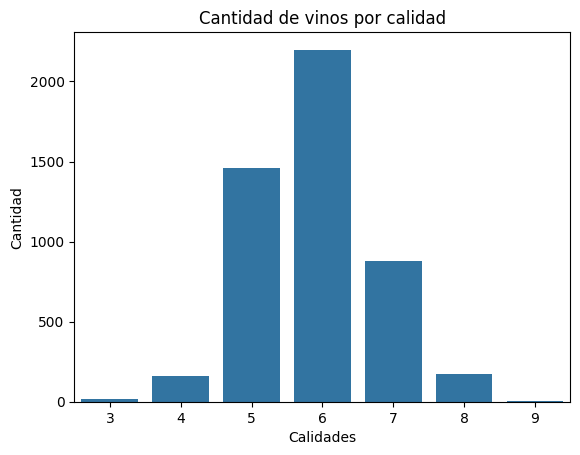

In [5]:
sns.countplot(x='quality',data=df_vinos)
plt.xlabel('Calidades')
plt.ylabel('Cantidad')
plt.title ('Cantidad de vinos por calidad')

Saco la matriz de correlación, para determinar las características más relevantes

In [6]:
df_vinos.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.022697,0.289181,0.089021,0.023086,-0.049396,0.091070,0.265331,-0.425858,-0.017143,-0.120881,-0.113663
volatile acidity,-0.022697,1.000000,-0.149472,0.064286,0.070512,-0.097012,0.089261,0.027114,-0.031915,-0.035728,0.067718,-0.194723
citric acid,0.289181,-0.149472,1.000000,0.094212,0.114364,0.094077,0.121131,0.149503,-0.163748,0.062331,-0.075729,-0.009209
residual sugar,0.089021,0.064286,0.094212,1.000000,0.088685,0.299098,0.401439,0.838966,-0.194133,-0.026664,-0.450631,-0.097577
chlorides,0.023086,0.070512,0.114364,0.088685,1.000000,0.101392,0.198910,0.257211,-0.090439,0.016763,-0.360189,-0.209934
free sulfur dioxide,-0.049396,-0.097012,0.094077,0.299098,0.101392,1.000000,0.615501,0.294210,-0.000618,0.059217,-0.250104,0.008158
total sulfur dioxide,0.091070,0.089261,0.121131,0.401439,0.198910,0.615501,1.000000,0.529881,0.002321,0.134562,-0.448892,-0.174737
density,0.265331,0.027114,0.149503,0.838966,0.257211,0.294210,0.529881,1.000000,-0.093591,0.074493,-0.780138,-0.307123
pH,-0.425858,-0.031915,-0.163748,-0.194133,-0.090439,-0.000618,0.002321,-0.093591,1.000000,0.155951,0.121432,0.099427
sulphates,-0.017143,-0.035728,0.062331,-0.026664,0.016763,0.059217,0.134562,0.074493,0.155951,1.000000,-0.017433,0.053678


Buscamos las posibles correlaciones con mapa de calor
- redondeo a dos decimales, para que la representación sea interpretable

- RdYlGn - Colores del mapa de calor (Rojo(Rd) - Amarillo(Yl) - Verde(Gn)

Se observa cierta correlacion entre el azúcar residual y la densidad (0.84)

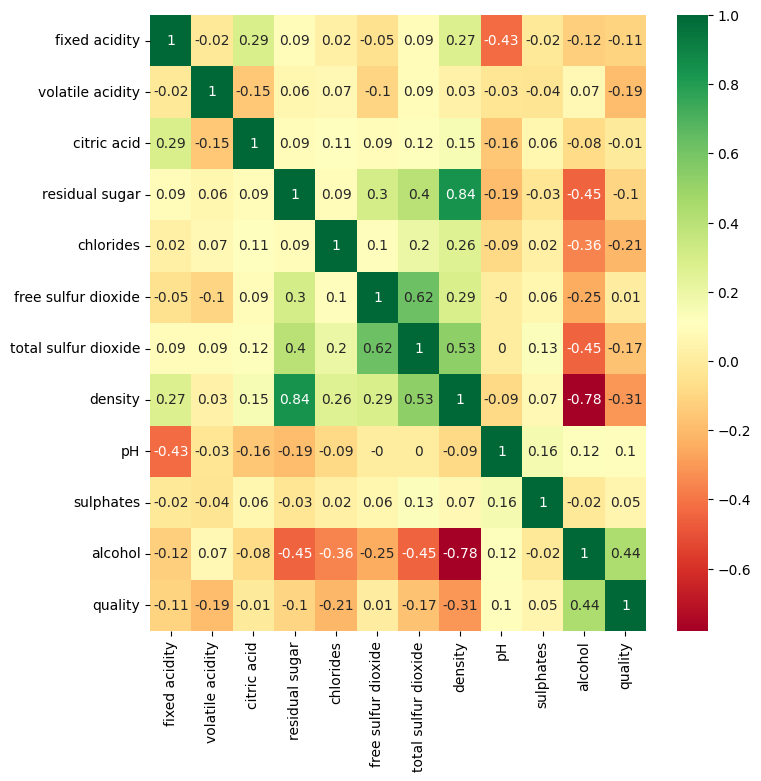

In [7]:
sns.heatmap(df_vinos.corr().round(2),annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(8,8) # tamaño de la visualización
plt.show()


**Matriz de dispersión(Gráficos de dispersión)**




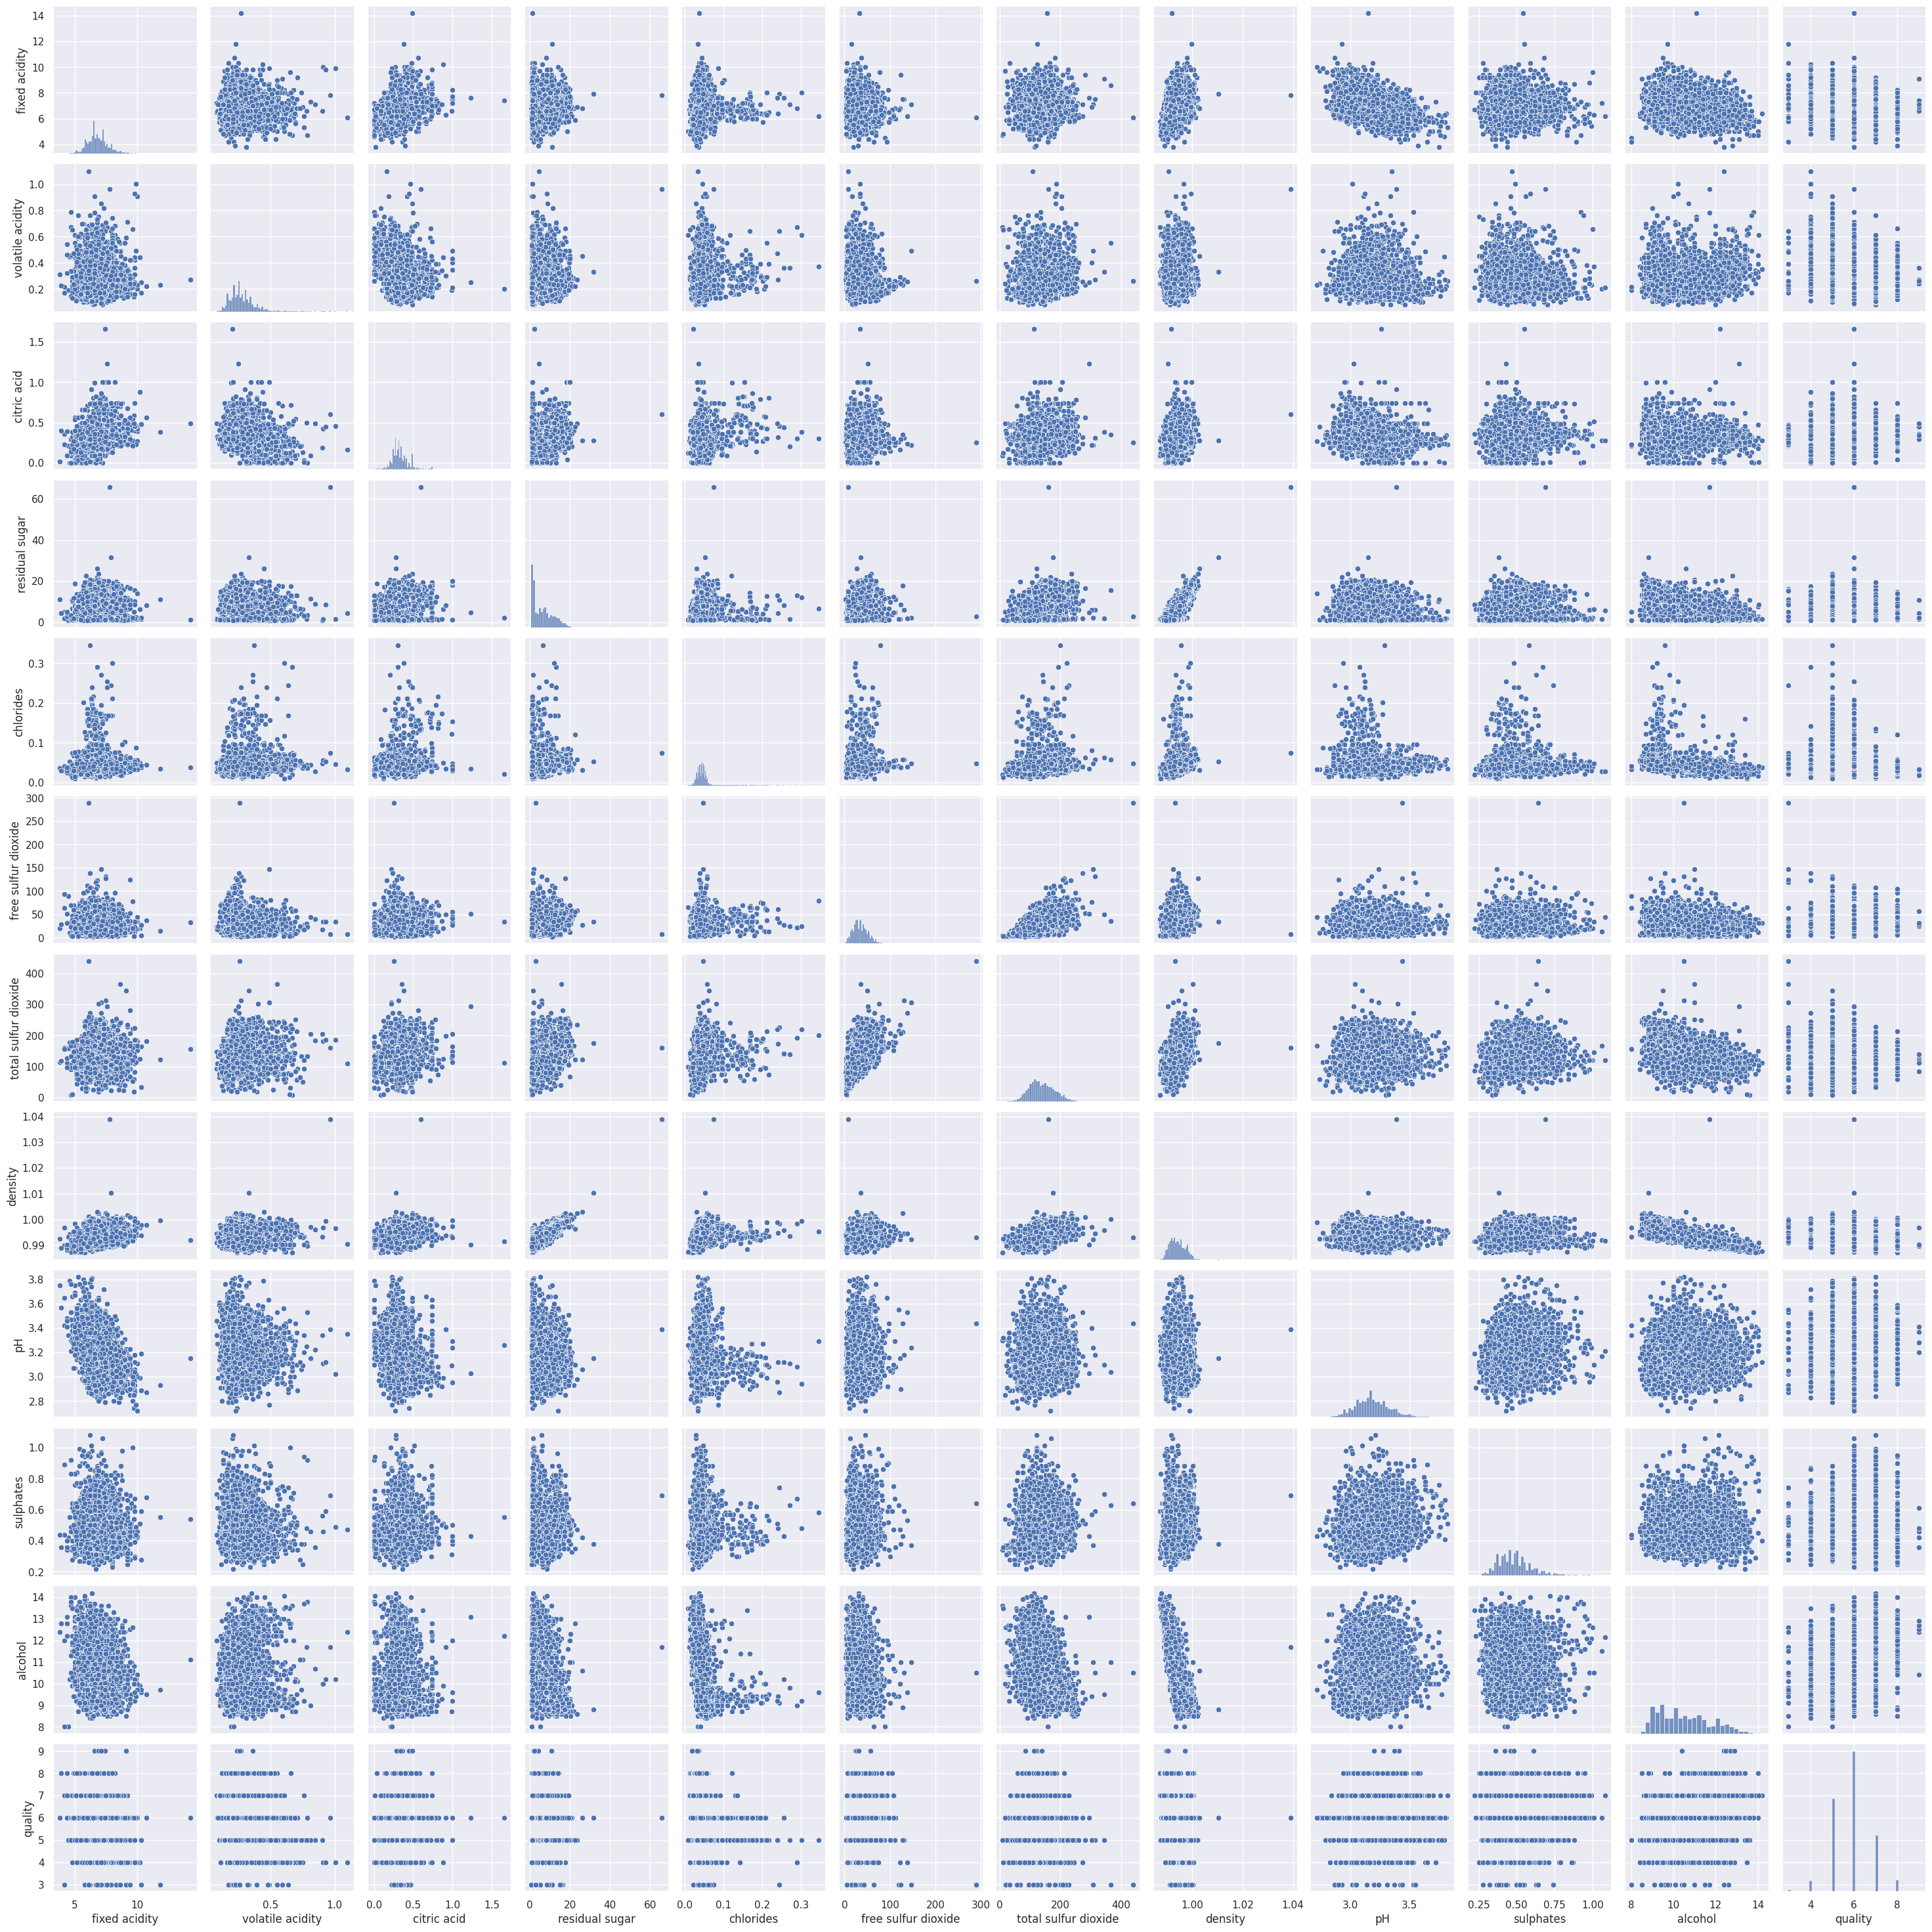

In [8]:
sns.set()
sns.pairplot(df_vinos, size = 2.5)
plt.show();

Utilizo *selectKbest*, para intentar diferenciar las características más relevantes, dde las que no lo son.
El método ***score*** aporta la puntuación que toma *selectkbest* para determinar cuáles son las características más relevantes. A mayor puntuación, la característica está más relacionada con la variable objetivo (y).

Se calcula como la diferencia entre la puntuación de la característica y la puntuación promedio de todas las demás características.

Hay cuatro características que superan el 20% de puntuación. Por lo que me quedo con esas.

In [9]:
selector = SelectKBest(f_classif, k=11) # En K le indicamos el número de características que queremos seleccionar
x_carac_seleccionadas = selector.fit(df_vinos.iloc[:,:-1],df_vinos[df_vinos.columns[-1]])

# Aquí saco la puntuación que han obtenido las diferentes características, según SelectKBest
scores = selector.scores_
print(scores)
# Muestra las características seleccionadas
X_char_selected = selector.fit(df_vinos.iloc[:,:-1], df_vinos[df_vinos.columns[-1]])
# En este ejemplo no excluye ninguna característica al no haber correlación, cuando k=3
char_selected = X_char_selected.get_feature_names_out(None)
char_selected

[ 12.89479161  61.91673868   3.24574509  21.27028518  42.47225198
  19.72367444  45.20094879 105.85643385  10.10328912   3.64231688
 229.73477227]


array(['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
      dtype=object)

Nos desembarazamos de las demás columnas

In [12]:
X_train = df_vinos.drop(['fixed acidity','citric acid', 'residual sugar'
                          , 'free sulfur dioxide','pH','sulphates'], axis=1)

X_train

,volatile acidity,chlorides,total sulfur dioxide,density,alcohol,quality
0,0.27,0.045,170.0,1.00100,8.8,6
1,0.30,0.049,132.0,0.99400,9.5,6
2,0.28,0.050,97.0,0.99510,10.1,6
3,0.23,0.058,186.0,0.99560,9.9,6
4,0.23,0.058,186.0,0.99560,9.9,6
...,...,...,...,...,...,...
4893,0.21,0.039,92.0,0.99114,11.2,6
4894,0.32,0.047,168.0,0.99490,9.6,5
4895,0.24,0.041,111.0,0.99254,9.4,6
4896,0.29,0.022,110.0,0.98869,12.8,7


Separo las características del objetivo del estudio, la calidad del vino

In [13]:
# y_vinos = df_vinos['quality']
y_vinos = X_train.drop(['volatile acidity','chlorides','total sulfur dioxide','density','alcohol'],axis=1)
X_vinos = X_train.drop(['quality'], axis=1)


print(X_vinos,y_vinos)

      volatile acidity  chlorides  total sulfur dioxide  density  alcohol
0                 0.27      0.045                 170.0  1.00100      8.8
1                 0.30      0.049                 132.0  0.99400      9.5
2                 0.28      0.050                  97.0  0.99510     10.1
3                 0.23      0.058                 186.0  0.99560      9.9
4                 0.23      0.058                 186.0  0.99560      9.9
...                ...        ...                   ...      ...      ...
4893              0.21      0.039                  92.0  0.99114     11.2
4894              0.32      0.047                 168.0  0.99490      9.6
4895              0.24      0.041                 111.0  0.99254      9.4
4896              0.29      0.022                 110.0  0.98869     12.8
4897              0.21      0.020                  98.0  0.98941     11.8

[4898 rows x 5 columns]       quality
0           6
1           6
2           6
3           6
4           6
...

Escalo las características, antes de comenzar el estudio. Min Max Scales normalizará todos los valores entre 0 y 1

In [14]:
scaler= MinMaxScaler()
X_vinos = scaler.fit_transform(X_vinos)
X_vinos

array([[0.18627451, 0.10682493, 0.37354988, 0.26778485, 0.12903226],
       [0.21568627, 0.11869436, 0.28538283, 0.13283208, 0.24193548],
       [0.19607843, 0.12166172, 0.20417633, 0.15403894, 0.33870968],
       ...,
       [0.15686275, 0.09495549, 0.23665893, 0.10468479, 0.22580645],
       [0.20588235, 0.03857567, 0.23433875, 0.03046077, 0.77419355],
       [0.12745098, 0.03264095, 0.20649652, 0.04434162, 0.61290323]])

Aplico Cross-Validation

In [15]:
def cv_modelo (modelo,s):
  cv = StratifiedKFold(n_splits=s, shuffle = True)
  cv_accu=[]
  # como el StratifiedKFold utiliza arrays de numpy, hay que convertir nuestros orígenes de datos
  X_train_vinos= np.array(X_vinos)
  y_train_vinos= np.array(y_vinos)
  for cv_train, cv_test in cv.split(X_train_vinos, y_train_vinos):
    # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
    # cv_train_x = X_train_vinos.iloc[cv_train]
    cv_train_x = X_train_vinos[cv_train]
    # cv_train_y = y_train_vinos.iloc[cv_train]
    cv_train_y = y_train_vinos[cv_train]
    #     cv_train_y= cv_train_y.apply(lambda x: x - 3)
    cv_train_y -=3 # para que el modelo GradientBoostingClassifier pueda trabajar con los datos de y
    # vamos entrenando los modelos
    modelo.fit(cv_train_x, cv_train_y)
    y_test=y_vinos.iloc[cv_test].values
    y_test -=3
    #guardo el predict de cada modelo
    y_pred = modelo.predict(X_vinos[cv_test])
    accu= accuracy_score(y_test,y_pred)
    cv_accu.append(accu)

  # Calculo la precisión media y la devuelvo
  accu_media=sum(cv_accu)/len(cv_accu)
  return accu_media

Método para opitimizar el número de splits en el que se consigue una precisión máxima

In [16]:
def calcular_splits(modelo):
  accu_max=0.1
  accu=0.1
  split_dec=0
  for i in range(2,100,5):
    accu=cv_modelo (modelo,i)
    if accu>accu_max:
        accu_max=accu
        split_dec=i
  print ("Modelo %s Accuracy máxima: = %.4f para %d splits" %  (modelo,accu_max,split_dec ))

Voy entrenando los modeos con distinto número de splits, para obtener el mejor resultado

In [17]:
%%time
# DecisionTreeClassifier
calcular_splits(DecisionTreeClassifier())

# RandomForestClassifier
calcular_splits(RandomForestClassifier())

# GradientBoostingClassifier
calcular_splits(GradientBoostingClassifier())

# xgb.XGBClassifier
calcular_splits(xgb.XGBClassifier(n_estimators=100))

Modelo DecisionTreeClassifier() Accuracy máxima: = 0.6382 para 47 splits
Modelo RandomForestClassifier() Accuracy máxima: = 0.6970 para 77 splits
Modelo GradientBoostingClassifier() Accuracy máxima: = 0.5792 para 12 splits
Modelo XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...) Accu

Entreno el modelo con CrossValidation, para RandomForest , que es el que devuelve más precisión (69.70%), como el número de splits termina en 7, no es necesario buscar con más precisión.


Busco el número óptimo de árboles (estimators). Aplicamos el modelo y número de splits obtenidos anteriormente RandomForestClassifier y 77 splits.


In [18]:
def Optimiza (criterio, estimators):
  accu_max=0.1
  accu=0.1
  # Con el parámetro n_estimator se indica el número de árboles en el bosque
  # el parámetro criterion es el criterio que se va a utilizar para medir la calidad de una división
  modelo =  RandomForestClassifier(n_estimators= estimators, criterion=criterio, random_state=0)
  cv = StratifiedKFold(n_splits=77, shuffle = True)
  cv_accu=[]
  # como el StratifiedKFold utiliza arrays de numpy, hay que convertir nuestros orígenes de datos
  X_train_vinos= np.array(X_vinos)
  y_train_vinos= np.array(y_vinos)
  for cv_train, cv_test in cv.split(X_train_vinos, y_train_vinos):
    # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
    # cv_train_x = X_train_vinos.iloc[cv_train]
    cv_train_x = X_train_vinos[cv_train]
    # cv_train_y = y_train_vinos.iloc[cv_train]
    cv_train_y = y_train_vinos[cv_train]
    #     cv_train_y= cv_train_y.apply(lambda x: x - 3)
    cv_train_y -=3 # para que el modelo GradientBoostingClassifier pueda trabajar con los datos de y
    # vamos entrenando los modelos
    modelo.fit(cv_train_x, cv_train_y)
    y_test=y_vinos.iloc[cv_test].values
    y_test -=3
    #guardo el predict de cada modelo
    y_pred = modelo.predict(X_vinos[cv_test])
    accu= accuracy_score(y_test,y_pred)
    cv_accu.append(accu)

  # Calculo la precisión media y la devuelvo
  accu_media=sum(cv_accu)/len(cv_accu)
  return accu_media

Busco el mejor criterio y número óptimo de estimators - Gini - 18 estimators 70.55 % Accuracy

In [19]:
accu_max=0.1
accu=0.1
arboles=0
for i in range(1,20):
  accu=Optimiza('gini',i)
  if accu>accu_max:
      accu_max=accu
      arboles=i
print ("Modelo Gini Accuracy máxima: = %.4f para %d estimators" %  (accu_max,arboles ))


Modelo Gini Accuracy máxima: = 0.6809 para 19 estimators


Entropy - 16 estimators 69.31% Accuracy

In [20]:
accu_max=0.1
accu=0.1
arboles=0
for i in range(1,20):
  accu=Optimiza('entropy',i)
  if accu>accu_max:
      accu_max=accu
      arboles=i
print ("Modelo Entropy Accuracy máxima: = %.4f para %d estimators" %  (accu_max,arboles ))

Modelo Entropy Accuracy máxima: = 0.6836 para 15 estimators


Separo los conjuntos de entrenamiento, validación y test (60% - 20% - 20%) Stratify yes, para que balancee las y, en los distintos conjuntos


In [21]:
X_train, X_resto, y_train, y_resto = train_test_split(X_vinos, y_vinos, test_size=0.4, random_state=42, stratify=y_vinos)

# Dividir el resto en validación y prueba (50% cada uno)
X_val, X_test, y_val, y_test = train_test_split(X_resto, y_resto, test_size=0.5, random_state=42, stratify=y_resto)


Entreno el modelo elegido Random Forest, criterio entropy y 15 estimators



In [23]:
# Crear el modelo RandomForestClassifier con criterio Gini y 18 estimadores
modelo_rf_gini = RandomForestClassifier(n_estimators=15, criterion='entropy', random_state=42)
modelo_rf_gini.fit(X_vinos, y_vinos)

# Realizar predicciones en el conjunto de prueba
y_pred_gini = modelo_rf_gini.predict(X_val)

exactitud_validacion = accuracy_score(y_val, y_pred_gini)
print(f"Precisión en el conjunto de validación: {exactitud_validacion:.2f}")

informe_clasificacion = classification_report(y_val, y_pred_gini)
print("Informe de clasificación en el conjunto de validación:\n", informe_clasificacion)

Precisión en el conjunto de validación: 0.99
Informe de clasificación en el conjunto de validación:
               precision    recall  f1-score   support

           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00        32
           5       1.00      1.00      1.00       292
           6       0.99      1.00      1.00       440
           7       0.99      0.98      0.99       176
           8       1.00      0.97      0.99        35
           9       1.00      1.00      1.00         1

    accuracy                           0.99       980
   macro avg       1.00      0.99      1.00       980
weighted avg       0.99      0.99      0.99       980



Confusion matrix, without normalization
[[  18    0    2    0    0    0    0]
 [   0  162    1    0    0    0    0]
 [   0    1 1449    6    1    0    0]
 [   0    0    5 2192    1    0    0]
 [   0    0    2    7  871    0    0]
 [   0    0    0    1    3  171    0]
 [   0    0    0    0    0    0    5]]
Normalized confusion matrix
[[9.00000000e-01 0.00000000e+00 1.00000000e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.93865031e-01 6.13496933e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.86341798e-04 9.94509266e-01 4.11805079e-03
  6.86341798e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.27479527e-03 9.97270246e-01
  4.54959054e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.27272727e-03 7.95454545e-03
  9.89772727e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.71428571e-03
  1.71428571e-02 9.77142857e-01 0.00000000e+00]
 [0.0

<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

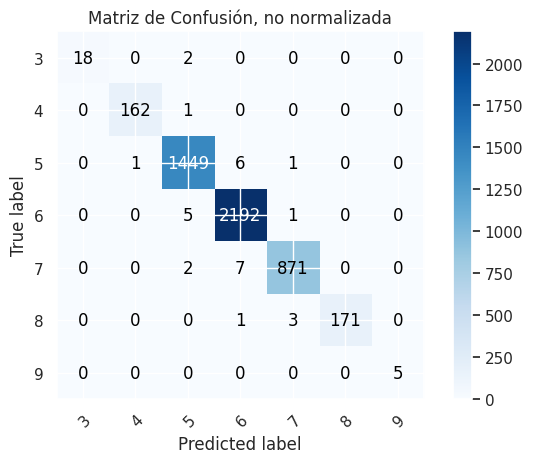

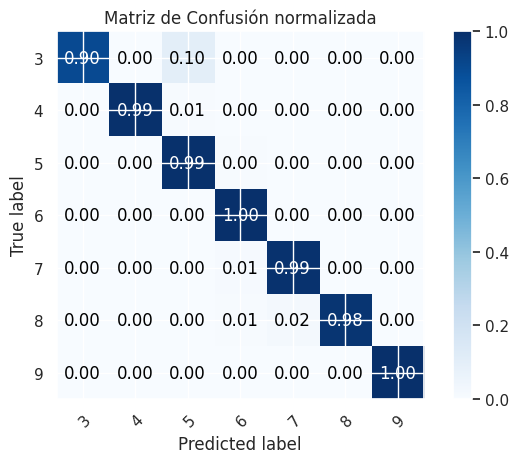

In [26]:
# Realizar predicciones en el conjunto de prueba
y_pred = modelo_rf_gini.predict(X_vinos)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_vinos, y_pred)
plot_confusion_matrix(y_vinos, y_pred,classes= np.array(['0',',1','2','3','4','5','6','7','8','9','10']) , normalize=False)
plot_confusion_matrix(y_vinos, y_pred,classes= np.array(['0',',1','2','3','4','5','6','7','8','9','10']) , normalize=True)

Función para dibujar la matriz de confusión

In [25]:
# y_true : dataframe -> Los valores de las clases que son ciertos (test)
# y_pred : ndarray   -> Los valores calculados de las clases después de realizar la predicción
# class  : ndarray   -> Los nombres de las clases/valores objetivos

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          titleSup=None):
    if not title:
        if normalize:
            title = 'Matriz de Confusión normalizada'
        else:
            title = 'Matriz de Confusión, no normalizada'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.suptitle(titleSup, fontsize=16, y=1, ha='center')
    return ax

Exporto el modelo a un fichero

In [28]:
# Para exportar el modelo a un fichero

joblib.dump(modelo_rf_gini,'ClasificacionVinosBlancosRandomForest.pkl')

['ClasificacionVinosBlancosRandomForest.pkl']

Importo el modelo pre entrenado.


In [29]:
modelo_cargado=joblib.load('ClasificacionVinosBlancosRandomForest.pkl')

Aplico el modelo sobre los datos de test

Confusion matrix, without normalization
[[  18    0    2    0    0    0    0]
 [   0  162    1    0    0    0    0]
 [   0    1 1449    6    1    0    0]
 [   0    0    5 2192    1    0    0]
 [   0    0    2    7  871    0    0]
 [   0    0    0    1    3  171    0]
 [   0    0    0    0    0    0    5]]
Normalized confusion matrix
[[9.00000000e-01 0.00000000e+00 1.00000000e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.93865031e-01 6.13496933e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.86341798e-04 9.94509266e-01 4.11805079e-03
  6.86341798e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.27479527e-03 9.97270246e-01
  4.54959054e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.27272727e-03 7.95454545e-03
  9.89772727e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.71428571e-03
  1.71428571e-02 9.77142857e-01 0.00000000e+00]
 [0.0

<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

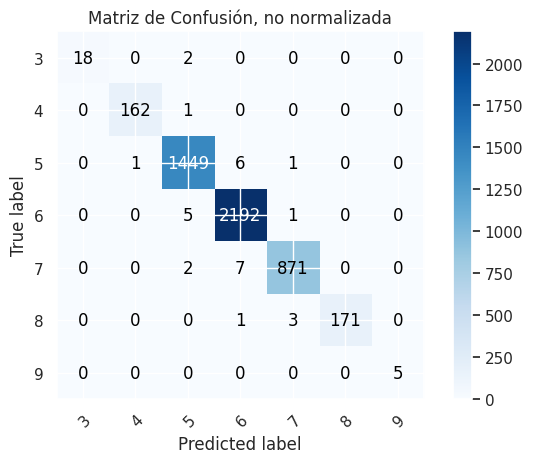

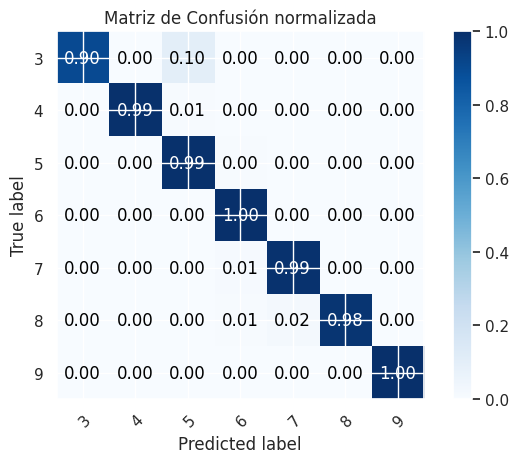

In [30]:
# Realizar predicciones en el conjunto de prueba
y_pred = modelo_cargado.predict(X_vinos)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_vinos, y_pred)
plot_confusion_matrix(y_vinos, y_pred,classes= np.array(['0',',1','2','3','4','5','6','7','8','9','10']) , normalize=False)
plot_confusion_matrix(y_vinos, y_pred,classes= np.array(['0',',1','2','3','4','5','6','7','8','9','10']) , normalize=True)